In [38]:
import pandas as pd 
import numpy as np
import ast
from tqdm import tqdm


In [2]:
from preprocess import  preprocess_metadata
from evaluation import evaluate_search_system 
from semantic_search import semantic_search ,enhanced_search, generate_embeddings
from utils import convert_embedding_string_to_array, display_search_results

## Data loading and cleaning

In [4]:
queries = pd.read_csv("../data/queries.csv")

test_queries = pd.read_csv("../data/test_queries.csv")
test_queries=list(test_queries['query'])

items = pd.read_csv("../data/5k_items_processed.csv")

In [4]:
items

,_id,itemId,itemMetadata,itemProfile,merchantId,jointText,organic,lacFree,vegan,avgBasketPrice,total_orders,reorderRate,embeddings_jointText,jointTextNatural,category_name,embeddings_jointTextNatural
0,6813b2b5b7476b2ec454b7ff,442731c2-144b-4c5c-b81e-e0cf9dfa9630,"{""category_name"":""Alimentos Básicos"",""descript...","{""metrics"":{""avgBasketPrice"":159.89,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Macarrão Pena com Ovos Adria 500g Pacote 500g ...,False,False,False,159.89,16,0.00,"[-0.008768842555582523, 0.0031782048754394054,...",Macarrão Pena com Ovos Adria 500g pertencente ...,Alimentos Básicos,"[-0.030683962628245354, 0.006260629277676344, ..."
1,6813b2b5b7476b2ec454b800,4a6d4a8f-c1bf-4457-a448-4a3b5e1eb20c,"{""category_name"":""Doces e Sobremesas"",""descrip...","{""metrics"":{""avgBasketPrice"":182.44,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Goplana Squares Pistache 200g Embalagem 200g D...,False,False,False,182.44,1,0.00,"[-0.02953251823782921, -0.03579430282115936, -...",Goplana Squares Pistache 200g pertencente à ca...,Doces e Sobremesas,"[-0.03905845806002617, -0.02474747598171234, -..."
2,6813b2b5b7476b2ec454b801,5380e263-c202-45cf-8eae-81e54573f122,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":190.63,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Creme para Pentear Boom Definição Intensa Seda...,False,False,False,190.63,3,0.00,"[0.05936675891280174, 0.020629625767469406, -0...",Creme para Pentear Boom Definição Intensa Seda...,Higiene e Cuidados Pessoais,"[0.05090884491801262, 0.03203822299838066, -0...."
3,6813b2b5b7476b2ec454b802,595ce305-ddf5-49fc-9a8c-b50a9ccf6267,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":113.56,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Desodorante Invisible For Black & White Aeroso...,False,False,False,113.56,3,0.00,"[0.05391239747405052, -0.03024141862988472, -0...",Desodorante Invisible For Black & White Aeroso...,Higiene e Cuidados Pessoais,"[0.04173634201288223, -0.013005441054701805, -..."
4,6813b2b5b7476b2ec454b803,5e2db3a9-1a2c-4462-8aa1-1ed045122e12,"{""category_name"":""Pet Shop"",""description"":""• R...","{""metrics"":{""avgBasketPrice"":223.58,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Ração Úmida para Cães Filhotes Frango Ao Molho...,False,False,False,223.58,1,0.00,"[0.06496849656105042, 0.01100705936551094, -0....",Ração Úmida para Cães Filhotes Frango Ao Molho...,Pet Shop,"[0.06125117465853691, 0.011424851603806019, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,6813b39eb7476b2ec454cb82,d4fe2d30-a824-4071-8bb7-9e70ab984db6,"{""category_name"":""Croissant & Brezel"",""descrip...","{""metrics"":{""avgBasketPrice"":78.99,""coPurchase...",bf0d36fe-8972-4b66-8247-38aba1254ae1,Croissant de manteiga tipo francês 70g Croisss...,False,False,False,78.99,6,0.17,"[0.0013472569407895207, 0.044463206082582474, ...",Croissant de manteiga tipo francês 70g pertenc...,Croissant & Brezel,"[-0.016537373885512352, 0.050034645944833755, ..."
4996,6813b39eb7476b2ec454cb83,3aeb7744-c99d-43dc-883f-4eec44d7d85b,"{""category_name"":""Lanches Saudáveis"",""descript...","{""metrics"":{""avgBasketPrice"":80.68,""coPurchase...",bf2834a7-754f-48cc-944f-cb14e65d580c,"Lanche Natural Caprese Tomate, rúcula, mussare...",False,False,False,80.68,5,0.33,"[0.0021305966656655073, 0.021863814443349838, ...",Lanche Natural Caprese pertencente à categoria...,Lanches Saudáveis,"[-0.004352240357547998, 0.02388005517423153, -..."
4997,6813b39eb7476b2ec454cb84,cf9963da-6971-4acb-a511-4663a4a500a7,"{""category_name"":""Bebidas"",""description"":""Garr...","{""metrics"":{""avgBasketPrice"":28.2,""coPurchaseI...",bf3d038c-eb28-419e-81c4-a8475bbea9b7,Coca-Cola Original 200ml Garrafa 200ml Bebidas...,False,False,False,28.20,1,0.00,"[0.03415736183524132, -0.008267918601632118, -...",Coca-Cola Original 200ml pertencente à categor...,Bebidas,"[0.00566784292459

In [ ]:
import json
items['jointText'] = items.apply(lambda row: preprocess_metadata(row['itemMetadata'], row['itemProfile'],type='Basic'), axis=1)

In [6]:
items['jointTextNatural'] = items.apply(lambda row: preprocess_metadata(row['itemMetadata'], row['itemProfile'],type='Natural'), axis=1)

In [10]:
items['organic'] = items.apply(lambda row: json.loads(row['itemMetadata'])['organic'], axis=1)
items['lacFree'] = items.apply(lambda row: json.loads(row['itemMetadata'])['lacFree'], axis=1)
items['vegan'] = items.apply(lambda row: json.loads(row['itemMetadata'])['vegan'], axis=1)
items['avgBasketPrice'] = items.apply(lambda row: json.loads(row['itemProfile'])["metrics"]['avgBasketPrice'], axis=1)
items['total_orders'] = items.apply(lambda row: json.loads(row['itemProfile'])["metrics"]['total_orders'], axis=1)
items['category_name'] = items.apply(lambda row: json.loads(row['itemMetadata'])['category_name'], axis=1)

In [97]:
reorderRate=[]
for i, row in items.iterrows():
    try:
        reorderRate.append(json.loads(row['itemProfile'])["metrics"]["reorderRate"])
    except:
        reorderRate.append(0.0)
items['reorderRate']=reorderRate

In [11]:
items.head(5)

,_id,itemId,itemMetadata,itemProfile,merchantId,jointText,organic,lacFree,vegan,avgBasketPrice,total_orders,reorderRate,embeddings_jointText,jointTextNatural,category_name
0,6813b2b5b7476b2ec454b7ff,442731c2-144b-4c5c-b81e-e0cf9dfa9630,"{""category_name"":""Alimentos Básicos"",""descript...","{""metrics"":{""avgBasketPrice"":159.89,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Macarrão Pena com Ovos Adria 500g Pacote 500g ...,False,False,False,159.89,16,0.0,"[-0.008768842555582523, 0.0031782048754394054,...",Macarrão Pena com Ovos Adria 500g pertencente ...,Alimentos Básicos
1,6813b2b5b7476b2ec454b800,4a6d4a8f-c1bf-4457-a448-4a3b5e1eb20c,"{""category_name"":""Doces e Sobremesas"",""descrip...","{""metrics"":{""avgBasketPrice"":182.44,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Goplana Squares Pistache 200g Embalagem 200g D...,False,False,False,182.44,1,0.0,"[-0.02953251823782921, -0.03579430282115936, -...",Goplana Squares Pistache 200g pertencente à ca...,Doces e Sobremesas
2,6813b2b5b7476b2ec454b801,5380e263-c202-45cf-8eae-81e54573f122,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":190.63,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Creme para Pentear Boom Definição Intensa Seda...,False,False,False,190.63,3,0.0,"[0.05936675891280174, 0.020629625767469406, -0...",Creme para Pentear Boom Definição Intensa Seda...,Higiene e Cuidados Pessoais
3,6813b2b5b7476b2ec454b802,595ce305-ddf5-49fc-9a8c-b50a9ccf6267,"{""category_name"":""Higiene e Cuidados Pessoais""...","{""metrics"":{""avgBasketPrice"":113.56,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Desodorante Invisible For Black & White Aeroso...,False,False,False,113.56,3,0.0,"[0.05391239747405052, -0.03024141862988472, -0...",Desodorante Invisible For Black & White Aeroso...,Higiene e Cuidados Pessoais
4,6813b2b5b7476b2ec454b803,5e2db3a9-1a2c-4462-8aa1-1ed045122e12,"{""category_name"":""Pet Shop"",""description"":""• R...","{""metrics"":{""avgBasketPrice"":223.58,""coPurchas...",d6cf7b73-c9bb-4c8a-abd6-c1a832bdd461,Ração Úmida para Cães Filhotes Frango Ao Molho...,False,False,False,223.58,1,0.0,"[0.06496849656105042, 0.01100705936551094, -0....",Ração Úmida para Cães Filhotes Frango Ao Molho...,Pet Shop


In [57]:
items['organic'].value_counts()

organic
False    4972
True       28
Name: count, dtype: int64

In [58]:
items['lacFree'].value_counts()

lacFree
False    4961
True       39
Name: count, dtype: int64

In [59]:
items['vegan'].value_counts()

vegan
False    4977
True       23
Name: count, dtype: int64

In [19]:
items['category_name'].value_counts()

category_name
Medicamentos                  483
Bebidas                       346
Higiene e Beleza              183
Limpeza                       181
Doces e Sobremesas            166
                             ... 
Potes de açaí                   1
Boquinha de Anjo                1
Master Hot Dogs Saborosos.      1
Clássicos na medida             1
Croissant & Brezel              1
Name: count, Length: 1339, dtype: int64

## Embedings Generation

### Baselines

In [ ]:
embeddings_items =generate_embeddings(items['jointText'])
embeddings_items_natural =generate_embeddings(items['jointTextNatural'])

In [ ]:
items['embeddings_jointText']=embeddings_items
items['embeddings_jointTextNatural']=embeddings_items_natural

In [35]:
items.to_csv("../data/5k_items_processed.csv", index=False)

In [36]:
query_embedding=generate_embeddings(queries['search_term_pt'])

In [5]:

item_embeddings = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointText']])
item_embeddings_natural = np.array([convert_embedding_string_to_array(emb) for emb in items['embeddings_jointTextNatural']])

Search Query: 'coca cola'
Top 10 Results:
--------------------------------------------------------------------------------
Rank 1: Coca cola   Lata
  Description: 
  Price: R$5.00
  Category: Refrigerante
  Similarity Score: 0.7092
  No image available
--------------------------------------------------------------------------------
Rank 2: Coca-Cola
  Description: 
  Price: R$0.00
  Category: Bebidas
  Similarity Score: 0.7064
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/8e7d4a1a-8a6d-44f3-91f4-c698edce5f0a/202109081142_G143_f.png
--------------------------------------------------------------------------------
Rank 3: Coca-Cola
  Description: 
  Price: R$16.00
  Category: Refrigerantes
  Similarity Score: 0.6922
  Image URL: https://static.ifood-static.com.br/image/upload/t_low/pratos/820af392-002c-47b1-bfae-d7ef31743c7f/202410251738_gacxmhpa7dk.jpeg
--------------------------------------------------------------------------------
Rank 4: Coca cola 350ml
  D

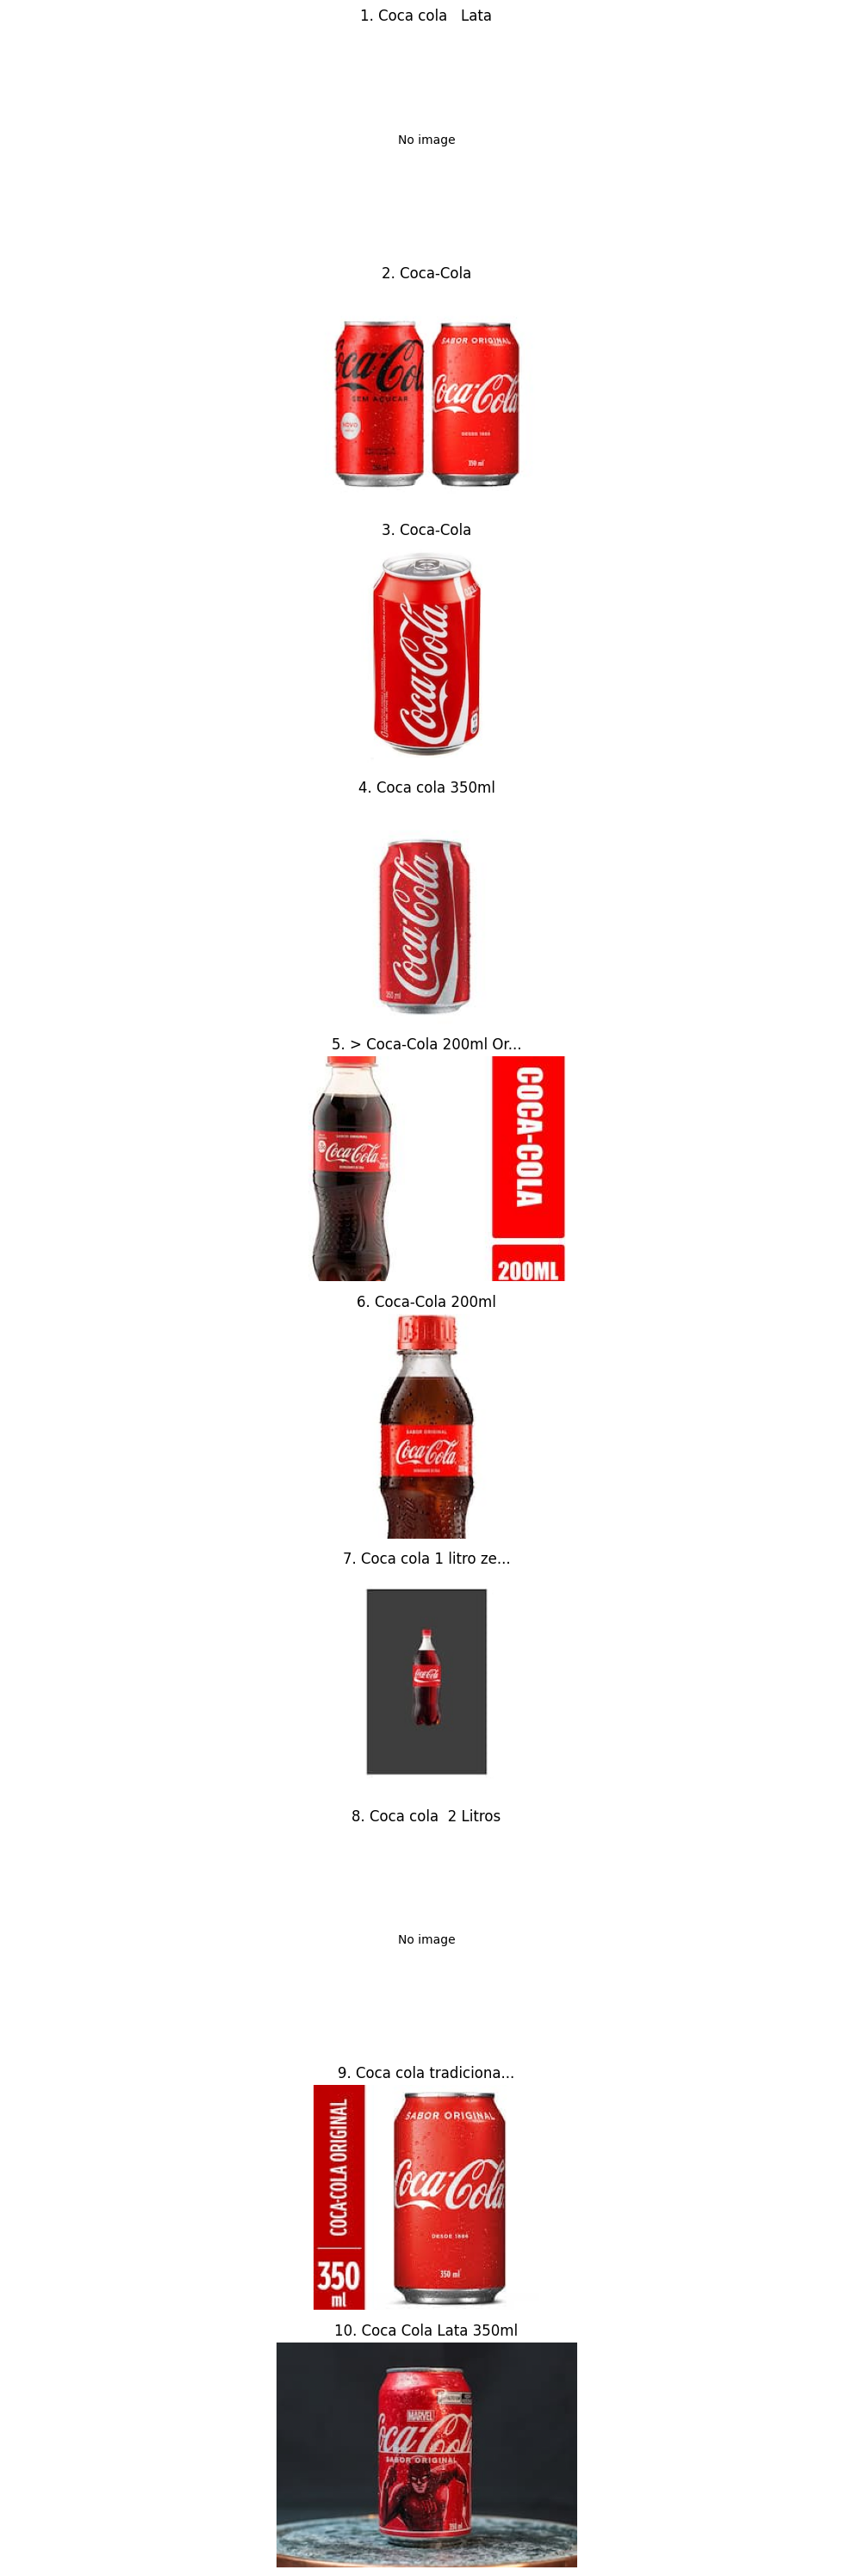

In [29]:
query = "coca cola"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
#item_embeddings = np.array(items['embeddings_jointText'])  # Assuming embeddings are stored in the DataFrame
items_df = items

# Display search results with images
top_indices, top_scores = display_search_results(query, query_embedding, item_embeddings, items_df, top_k=10)


In [37]:

results=[]
item_embeddings = np.array(embeddings_items_natural) 
for query in test_queries:
    query_embedding = generate_embeddings([query])[0] 
    top_indices, top_scores = semantic_search(query_embedding, item_embeddings, top_k=10)
    results.append(top_indices.tolist())

In [38]:
results

[[731, 1917, 0, 3698, 2071, 1358, 3920, 1423, 2962, 380],
 [2541, 4898, 4643, 4549, 3715, 730, 1689, 4849, 3854, 2743],
 [2, 1770, 3836, 444, 3481, 1612, 857, 3092, 4157, 554],
 [4169, 316, 474, 2659, 4094, 312, 4874, 609, 4097, 2748],
 [4, 4976, 2092, 211, 2933, 1242, 3286, 1446, 1440, 117],
 [5, 1213, 76, 4654, 3184, 2900, 2795, 1464, 1679, 2976],
 [6, 2483, 3033, 4442, 2622, 3930, 4650, 1396, 3123, 3794],
 [4543, 915, 7, 607, 3686, 4500, 4964, 1478, 2957, 3778],
 [8, 891, 582, 465, 1151, 3169, 3186, 2278, 1303, 2956],
 [4960, 3086, 4276, 2275, 1562, 54, 1062, 9, 659, 3610],
 [2613, 2754, 158, 546, 4351, 4904, 2001, 4267, 10, 2647],
 [1099, 153, 11, 14, 3177, 3963, 3152, 1941, 525, 4932],
 [1161, 2272, 784, 4989, 1164, 3753, 1196, 3544, 144, 3274],
 [13, 3821, 2497, 888, 17, 93, 2351, 2945, 378, 2905],
 [14, 2457, 525, 4193, 3963, 11, 929, 1941, 4932, 2343],
 [15, 3945, 1463, 172, 3873, 2255, 3834, 4786, 4322, 639],
 [16, 4494, 1906, 126, 589, 1032, 1592, 121, 3094, 1087],
 [17, 93, 

In [ ]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.566
average_rank: 4.025
hit_rate@1: 0.445
precision@1: 0.445
recall@1: 0.445
hit_rate@3: 0.640
precision@3: 0.213
recall@3: 0.640
hit_rate@5: 0.720
precision@5: 0.144
recall@5: 0.720
hit_rate@10: 0.795
precision@10: 0.079
recall@10: 0.795


In [19]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.560
average_rank: 3.975
hit_rate@1: 0.435
precision@1: 0.435
recall@1: 0.435
hit_rate@3: 0.675
precision@3: 0.225
recall@3: 0.675
hit_rate@5: 0.725
precision@5: 0.145
recall@5: 0.725
hit_rate@10: 0.810
precision@10: 0.081
recall@10: 0.810


### Re-Rank

In [6]:
query = "Arroz integral para alimentação saudável"
query_embedding = generate_embeddings([query])[0]  # Your embedding function
#item_embeddings = np.array(items['embeddings_jointText'])  # Assuming embeddings are stored in the DataFrame
items_df = items
top_k_indices, similarities=semantic_search(query_embedding, item_embeddings, top_k=30)

In [7]:
top_k_indices

array([4543,    7,  915,  607, 3686, 4500, 4964, 2593, 1478, 2957, 3778,
       1720, 2938, 3255,  677, 4638, 1358, 4800, 2471, 1426,  372, 3883,
       1044, 3978, 2278, 2005, 4888, 3621,  376, 4692])

In [26]:

# Simple search
results = enhanced_search(query="Arroz integral para alimentação saudável",item_embeddings=item_embeddings, items_df=items, top_k=10)
print("Top results:", results)



Top results: [607, 915, 7, 4543, 1358, 2593, 2957, 677, 4500]


In [32]:
results=[]
for query in test_queries:
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query ,item_embeddings, items_df=items, top_k=10)
    results.append(top_indices)

In [ ]:
for query in tqdm(test_queries, desc="Processing queries", unit="query"):
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query, item_embeddings, items_df=items, top_k=10)
    results.append(top_indices)

In [33]:
results

[[0, 1353, 4113, 1917, 731, 3698, 1358, 2071, 1423, 4311],
 [2541, 4898, 4549, 3715, 1912, 2743, 4644, 4849, 730, 1689],
 [2, 3481, 3092, 857, 4157, 554, 1770, 1612, 1058, 3836],
 [3777, 474, 2659, 2748, 3962, 4520, 609, 4874, 312, 2824],
 [4, 2092, 4976, 1242, 1446, 1440, 73, 117, 211, 2933],
 [5, 1679, 1213, 1970, 4654, 2900, 3184, 2795, 76, 681],
 [2483, 6, 3033, 3905, 2622, 3794, 1396, 4650, 3123, 4442],
 [607, 915, 7, 4543, 1358, 2957, 677, 2593, 1478, 1720],
 [8, 2278, 891, 2602, 3499, 165, 1303, 4123, 486, 1113],
 [3086, 4516, 1649, 659, 1062, 97, 54, 4276, 1898, 2275],
 [10, 2754, 4507, 158, 1715, 546, 1282],
 [1099, 153, 1941, 4708, 1937, 3963, 11, 2343, 900, 525],
 [4989, 12, 2272, 784, 3753, 3544, 1164, 590, 1196, 1161],
 [2497, 13, 3821, 888, 1172, 2905, 449, 508, 3599, 17],
 [14, 3963, 1937, 2343, 900, 525, 11, 4932, 3203, 153],
 [15, 3873, 1463, 3945, 172, 3834, 407, 1419, 4322, 2255],
 [16, 1592, 3082, 589, 126, 4494, 963, 121, 2107, 2566],
 [17, 2945, 93, 2497, 3327, 33

In [34]:
metrics = evaluate_search_system(test_queries, results)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.607
average_rank: 3.680
hit_rate@1: 0.495
precision@1: 0.495
recall@1: 0.495
hit_rate@3: 0.700
precision@3: 0.233
recall@3: 0.700
hit_rate@5: 0.760
precision@5: 0.152
recall@5: 0.760
hit_rate@10: 0.805
precision@10: 0.080
recall@10: 0.805


In [49]:
results2=[]
for query in tqdm(test_queries, desc="Processing queries", unit="query"):
    
    #query_embedding = generate_embeddings([query])[0] 
    top_indices = enhanced_search(query ,item_embeddings_natural, items_df=items, top_k=10)
    results2.append(top_indices)

Processing queries: 100%|██████████| 200/200 [30:47<00:00,  9.24s/query]


In [50]:
metrics = evaluate_search_system(test_queries, results2)
print("Evaluation Results:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")

Evaluation Results:
mrr: 0.577
average_rank: 3.900
hit_rate@1: 0.465
precision@1: 0.465
recall@1: 0.465
hit_rate@3: 0.670
precision@3: 0.223
recall@3: 0.670
hit_rate@5: 0.740
precision@5: 0.148
recall@5: 0.740
hit_rate@10: 0.790
precision@10: 0.079
recall@10: 0.790
